Esta fase de la metodologia consiste en extraer el valor de los datos desarrollando un modelo que aprenda de los patrones en estos.

* El diagrama en cuestion de esta fase esta a continuacion:

![Imagen_mapa](imagen_modelado_general.png)

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator #generator de imagenes
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import random

In [2]:
tf.keras.backend.clear_session()

In [3]:
tf.random.set_seed(42)#semilla 42, para la reproducibilidad de resultados
random.seed(42)
np.random.seed(42)

### Canalizacion de datos

* Preparamos la canalizacion de datos, a partir de las imagenes del disco.

In [4]:
train_datagen=ImageDataGenerator(
            rescale=1.0/255, #escalamos los datos en rangos de [-1,1] El modelo MobileNetv2 espera esta configuracion
            rotation_range = 45,
            zoom_range = 0.2,
            shear_range = 0.2,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            horizontal_flip=True,
            vertical_flip = True,
            fill_mode = 'nearest'
        )
#sobre los datos de validacion y test no se hace ningun aumento de datos.
validation_datagen=ImageDataGenerator(rescale=1.0/255) #escalamiento de validacion a un rango de [0,1]
test_datagen=ImageDataGenerator(rescale=1.0/255)       #escalamiento de test a un rango de [0,1]

In [5]:
#definimos las rutas para el acceso a los datos
train_path="../input/datasetv3/Datasets/train"
validation_path="../input/datasetv3/Datasets/val"
test_path="../input/datasetv3/Datasets/test"

#creamos los generadores de datos a partir de los flujos de informacion
BATCH_SIZE=32 #tamaño del lote que se ira pasando poco a poco
IMAGE_SIZE=(256,256)

train_generator=train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

validation_generator=validation_datagen.flow_from_directory(
    validation_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator=test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 15238 images belonging to 3 classes.
Found 1694 images belonging to 3 classes.
Found 4233 images belonging to 4 classes.


### Tecnica para el tratamiento de datos Desbalanceados. Penalizacion por pesos de clases

**penalizando los pesos de las clases** mayoritarias a favor de las clases minoritarias.


In [6]:
from sklearn.utils import class_weight

classes=train_generator.classes
class_weights=class_weight.compute_class_weight("balanced",np.unique(classes),classes)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[0 0 0 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [7]:
class_weights=dict(enumerate(class_weights))
print("Los pesos son {0}".format(class_weights))

Los pesos son {0: 1.950588837685612, 1: 0.9590886203423967, 2: 0.6921958753520487}


### Selección de tecnicas de Modelado

Al tratarse de un problema de clasificacion de imagenes entre los posibles candidatos tenemos:

* MultiLayer Pereptron: Red neuronal de capas densamente conectadas
* Convolutional Neuronal Network: Red neuronal convolucional.
* Modelos de machine learning clasico (Maquinas de soporte vectorial, arboles de decision e impulso, etc.)

Escogi la red neuronal convolucional porque **aprende de patrones locales** como rasgos pequeños y en bloques de informacion, mientras que el **MLP** aprende de patrones especficos, e decir de todo el espacio de entrada en general.


### Construcción de la arquitectura del modelo

* Para la construccion de la arquitectura crearemos un modelo con transferencia de aprendizaje con una arquitectura de red neuronal solida.



* Generando **Callbacks** para detener el entrenamiento cuando no se tienen buenos resultados


In [8]:
#cuando la funcion de perdida ya no mejora en los datos de validacion.
early_stopping=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=10,
                                                mode="min",
                                                restore_best_weights=True) 
model_checkpoint=tf.keras.callbacks.ModelCheckpoint("base_model_best_check.h5",save_best_only=True)
n_epochs=100

# Aplicación de Transfer Learning usando DenseNet169 y tecnica de anti-desbalanceo Penalización de clases

* Se escogio la arquitectura DenseNet169 por tener un mayor precision sobre el conjunto de datos Image.net en la que fue entrenado.

In [9]:
INPUT_SHAPE=(256,256,3)
BASE_LEARNING_RATE=0.0001
def build_model_transferLearning():
    dense_net169=tf.keras.applications.DenseNet169(
                weights="imagenet",
                input_shape=INPUT_SHAPE,
                include_top=False
            )
    #descongelamos algunas capas
    dense_net169.trainable=False
    for layer in dense_net169.layers:
        if 'conv5' in layer.name:
            layer.trainable=True
        else:
            layer.trainable=False
    #creamos el modelo
    inputs=tf.keras.Input(shape=INPUT_SHAPE)
    x=dense_net169(inputs)
    x=tf.keras.layers.Flatten()(x)
    
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(256,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.Dense(128,activation="relu")(x)
    x=tf.keras.layers.Dropout(0.4)(x)
    
    outputs=tf.keras.layers.Dense(3,activation="softmax")(x)
    
    model=tf.keras.Model(inputs,outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
        loss="categorical_crossentropy",
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.Recall(name="recall")    
        ]
    )
    return model

In [10]:
transfer_model=build_model_transferLearning()

51879936/51877672 [==============================] - 0s 0us/step


In [11]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 106496)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 106496)            425984    
_________________________________________________________________
dense (Dense)                (None, 256)               27263232  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024  

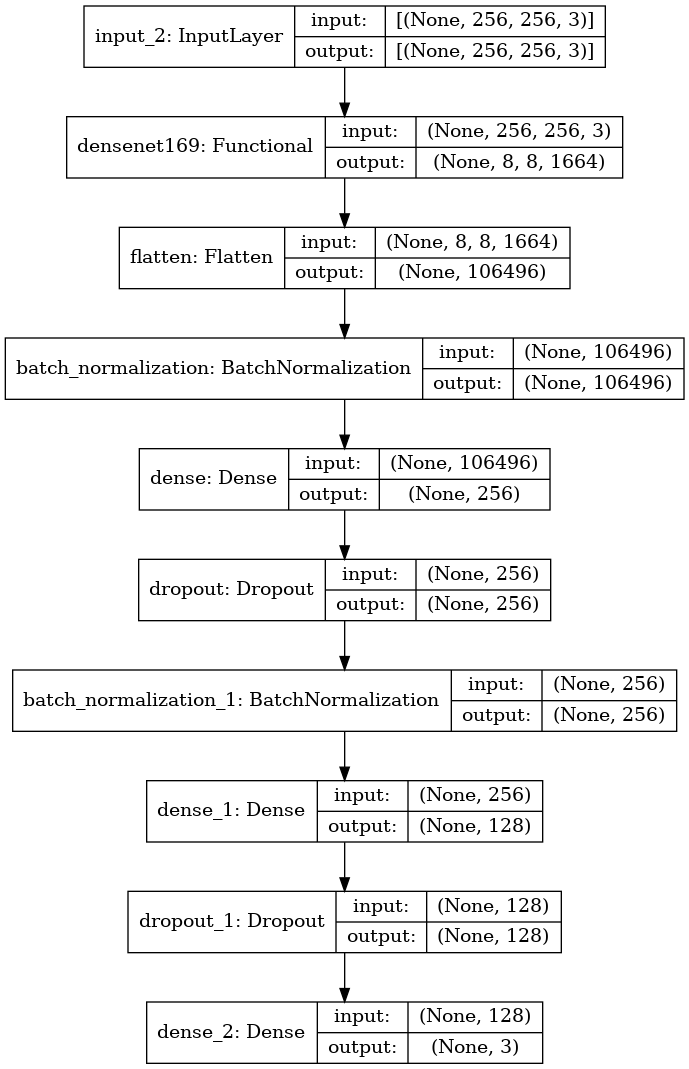

In [12]:
plot_model(transfer_model,"transfer_densenet.png",show_shapes=True)

#### ENTRENAMIENTO DEL MODELO

* El entrenamiento se realiza en **100 epocas**, un generador de datos de entrenamiento, un generador de datos de validacion, 2 callbacks para detener el entrenamiento de manera temprana en caso no se obtengan buenos resultados en base a la funcion de perdida en los datos de validacion durante 10 epocas consecutivas, y otra para guardar por puntos el mejor modelo obtenido hasta el momento.

In [13]:
transfer_model=build_model_transferLearning()
history_model=transfer_model.fit(
                    train_generator,
                    epochs=n_epochs,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples//validation_generator.batch_size,
                    callbacks=[early_stopping,model_checkpoint],
                    class_weight=class_weights,#penalizacion de pesos para el balanceo,
                    workers=8
            )

Epoch 1/100
477/477 [==============================] - 262s 503ms/step - loss: 0.8474 - accuracy: 0.6627 - recall: 0.6296 - val_loss: 0.5108 - val_accuracy: 0.7969 - val_recall: 0.7825
Epoch 2/100
477/477 [==============================] - 243s 502ms/step - loss: 0.5319 - accuracy: 0.7942 - recall: 0.7743 - val_loss: 0.3638 - val_accuracy: 0.8588 - val_recall: 0.8504
Epoch 3/100
477/477 [==============================] - 238s 494ms/step - loss: 0.4465 - accuracy: 0.8305 - recall: 0.8121 - val_loss: 0.3318 - val_accuracy: 0.8870 - val_recall: 0.8678
Epoch 4/100
477/477 [==============================] - 237s 488ms/step - loss: 0.3742 - accuracy: 0.8566 - recall: 0.8420 - val_loss: 0.3582 - val_accuracy: 0.8576 - val_recall: 0.8438
Epoch 5/100
477/477 [==============================] - 238s 491ms/step - loss: 0.3737 - accuracy: 0.8563 - recall: 0.8440 - val_loss: 0.3558 - val_accuracy: 0.8588 - val_recall: 0.8486
Epoch 6/100
477/477 [==============================] - 237s 491ms/step - lo

In [14]:
transfer_model.save("./tranferlearning_densenet169_with_balanced_focal_loss_3_class.h5")

In [15]:
def plot_metrics(history,metrics=[]): #retorna una lista de tuplas
    fig,axes=plt.subplots(1,len(metrics))
    fig.set_size_inches(15,5)
    graph=pd.DataFrame(history)
    for i,ax in enumerate(axes.flat):
        graph[list(metrics[i])].plot(kind="line",style="-",ax=ax)
        ax.set_title(" VS ".join(list(metrics[i])))
        ax.grid(True)
    plt.show()

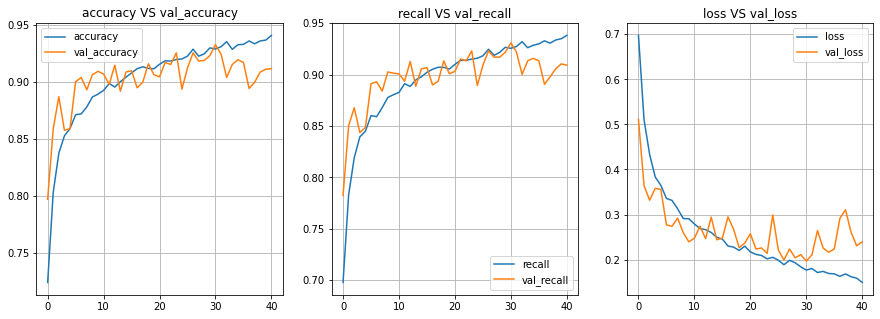

In [16]:
metrics=[("accuracy","val_accuracy"),("recall","val_recall"),("loss","val_loss")]
plot_metrics(history_model.history,metrics=metrics)

In [17]:
#obtenemos el numero de epocas donde se detuvo y lo configuramos como un epoch inicial para el siguiente
#entrenamiento
EPOCH_STOP=len(history_model.epoch)
print("El modelo se entreno en",EPOCH_STOP,"Epochs")

El modelo se entreno en 41 Epochs


* El entrenamiento del modelo se detuvo en 47 epochs lo que nos dice que la funcion de perdida en la data de validacion no mejoro por 10 epochs consecutivos, probablemente, ya no mejore para futuras epocas.

Ahora veamos el rendimiento del modelo base en los datos de entrenamiento y validacion

In [18]:
transfer_model.evaluate(train_generator)

477/477 [==============================] - 253s 530ms/step - loss: 0.1678 - accuracy: 0.9421 - recall: 0.9387


[0.16779577732086182, 0.9420527815818787, 0.9387058615684509]

In [19]:
transfer_model.evaluate(validation_generator)

53/53 [==============================] - 8s 149ms/step - loss: 0.1943 - accuracy: 0.9339 - recall: 0.9321


[0.19431829452514648, 0.93388432264328, 0.9321133494377136]

* Mostramos la matriz de confusion en los datos de entrenamiento y validacion

Para el conjunto de entrenamiento

In [20]:
y_true=train_generator.classes
predictions=transfer_model.predict(train_generator)
y_pred=np.argmax(predictions,axis=1)

In [21]:
print("Indices de clase")
for idx,clase in train_generator.class_indices.items():
    print(idx,":",clase)

Indices de clase
COVID : 0
Enfermedades Pulmonares No COVID19 : 1
Normal : 2


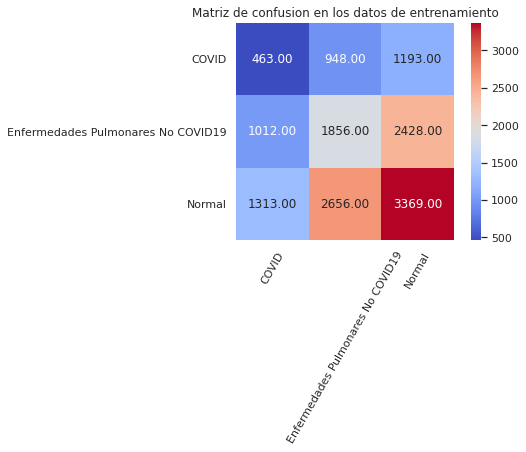

In [22]:
#obtenemos la matriz de confusion de sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()
classes=train_generator.class_indices.keys()
mat_train=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_train,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion en los datos de entrenamiento")
plt.show()

* Reporte de clasificacion para el conjunto de entrenamiento

In [23]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                                    precision    recall  f1-score   support

                             COVID       0.17      0.18      0.17      2604
Enfermedades Pulmonares No COVID19       0.34      0.35      0.35      5296
                            Normal       0.48      0.46      0.47      7338

                          accuracy                           0.37     15238
                         macro avg       0.33      0.33      0.33     15238
                      weighted avg       0.38      0.37      0.38     15238



* Para el conjunto de validacion

In [24]:
y_true=validation_generator.classes
predictions=transfer_model.predict(validation_generator)
y_pred=np.argmax(predictions,axis=1)

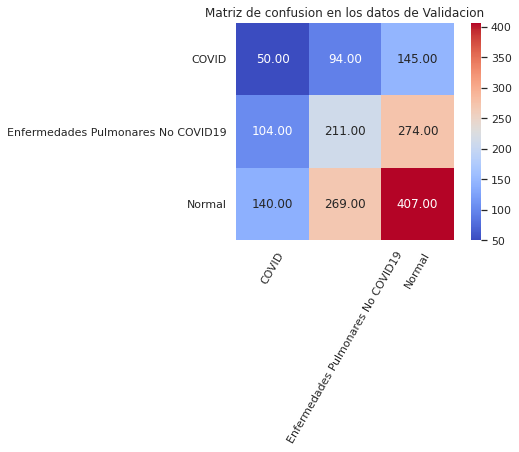

In [25]:
classes=validation_generator.class_indices.keys()
mat_val=confusion_matrix(y_true,y_pred)
sns.heatmap(mat_val,square=True,annot=True,fmt="0.2f",cmap="coolwarm",xticklabels=classes,yticklabels=classes)
plt.xticks(rotation=60)
plt.title("Matriz de confusion en los datos de Validacion")
plt.show()

* Reporte de clasificacion para los datos de validacion

In [26]:
report=classification_report(y_true,y_pred,target_names=list(train_generator.class_indices.keys()))
print(report)

                                    precision    recall  f1-score   support

                             COVID       0.17      0.17      0.17       289
Enfermedades Pulmonares No COVID19       0.37      0.36      0.36       589
                            Normal       0.49      0.50      0.50       816

                          accuracy                           0.39      1694
                         macro avg       0.34      0.34      0.34      1694
                      weighted avg       0.39      0.39      0.39      1694



### RESULTADOS FINALES: MODELO TRANFER LEARNING CON PENALIZACION DE PESOS PARA EL BALANCEO DE CLASES. USANDO 3 CLASES
* El modelo base ha obtenido un puntaje de accuracy **ACC=94.21%** y recall **RECALL=93.87%** en el **conjunto de entrenamiento**.

* El modelo ha obtendio un puntaje de accuracy **ACC=93.39%** y recall **RECALL=93.21%** en el **conjunto de validacion**.

**IMPORTANTE**: El modelo ha alcanzado  equilibrio entre los datos de entrenamiento y validacion, lo que significa que es un modelo final con aproximadamente 93% de precision. Este modelo pasará a la **Fase de evaluación del modelo**.